In [1]:
import torch
print(torch.cuda.is_available())
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(4,4)
from scanpy import AnnData

True


In [2]:
import sys
sys.path.append('models/')
import os
print(os.listdir('models/'))
from split_cross_ae import SplitCrossAE, compute_loss, train_step

['.ipynb_checkpoints', 'mct_crossae.py', 'mct_splitae.py', 'split_cross_ae.py', '__pycache__']


In [3]:
data_left_HVG=pd.read_hdf('DATA/data_left_prepared.h5',key='data')
data_left_HVG.shape

(3290, 1013)

In [4]:
# data_right=pd.read_hdf('DATA/data_right_prepared.h5',key='data')
# data_right.shape

In [5]:
data_left_LVG=pd.read_hdf('DATA/data_left_prepared_full.h5',key='data')
print(data_left_LVG.shape)
data_left_LVG=data_left_LVG[[c for c in data_left_LVG.columns if c not in data_left_HVG]]
print(data_left_LVG.shape)
# data_right_LVG=pd.read_hdf('DATA/data_right_prepared.h5',key='data')
# print(data_righ_LVGt.shape)

(3290, 37204)
(3290, 36191)


# Data Loader

In [6]:
from torch.utils.data import Dataset, DataLoader
class JointSplit_Dataset(Dataset):
    def __init__(self, data_left_HVG,data_left_LVG):
        self.data_left_HVG=data_left_HVG
        self.data_left_LVG=data_left_LVG
#         self.data_right = data_right
    def __len__(self,):
        return len(self.data_left_HVG)
    def __getitem__(self,index):
        return self.data_left_HVG[index],self.data_left_LVG[index]


In [7]:
# data_left=data_left.loc[data_right.index]
x_train_left_HVG=torch.tensor(data_left_HVG.values,dtype=torch.float32)
x_train_left_LVG=torch.tensor(data_left_LVG.values,dtype=torch.float32)
#x_train_right=torch.tensor(data_right.values,dtype=torch.float32)

In [8]:
from sklearn.model_selection import train_test_split
data_left_HVG_train, data_left_HVG_test, data_left_LVG_train, data_left_LVG_test= train_test_split(
    data_left_HVG ,data_left_LVG, test_size=0.2, random_state=42)
x_train_left_HVG, x_test_left_HVG, x_train_left_LVG, x_test_left_LVG = [
    torch.tensor(i.values, dtype=torch.float32) 
    for i in [data_left_HVG_train, data_left_HVG_test, data_left_LVG_train, data_left_LVG_test]
]
print(x_train_left_HVG.shape)
print(x_test_left_HVG.shape)
print(x_train_left_LVG.shape)
print(x_test_left_LVG.shape)

torch.Size([2632, 1013])
torch.Size([658, 1013])
torch.Size([2632, 36191])
torch.Size([658, 36191])


# Model 

In [9]:
x_train_left_LVG.shape[1]

36191

In [10]:
input_dim_left_HVG=x_train_left_HVG.shape[1]
input_dim_left_LVG = x_train_left_LVG.shape[1]
latent_dim=64
splitcrossae=SplitCrossAE(input_dim_left_HVG,input_dim_left_LVG,latent_dim)
optimizer=optim.Adam(splitcrossae.parameters(),lr=0.01, weight_decay=1e-5)

In [11]:
jointsplit_dataset=JointSplit_Dataset(x_train_left_HVG,x_train_left_LVG)
jointsplit_dataloader=DataLoader(dataset=jointsplit_dataset,batch_size=32,shuffle=True)

In [ ]:
%%time
batch_size=256
epochs=10000
min_loss=np.Inf
last_loss_update=0
for epoch in range(epochs):
    for batch_data_left_HVG,batch_data_left_LVG  in jointsplit_dataloader:
        loss=train_step(splitcrossae,batch_data_left_HVG,batch_data_left_LVG,optimizer)
#         print(loss)
    if loss< min_loss:
        min_loss=loss
        last_loss_update=0
    else:
        last_loss_update+=1
    if last_loss_update>=20:
        print('No loss improvment in 10 epochs')
        break
    if epoch%10==0:
        print('Epoch: '+str(epoch), 'Loss: '+str(loss))

Epoch: 0 Loss: 0.000531944795511663
Epoch: 10 Loss: 0.00044040355714969337
Epoch: 20 Loss: 0.0004177942464593798
Epoch: 30 Loss: 0.00043681662646122277


# Generate Data

In [ ]:
recon_mcg_HVG_train,recon_mcg_LVG_train=splitcrossae.predict_from_left(x_train_left_HVG,x_train_left_LVG)
recon_mcg_HVG_train.shape

In [17]:
recon_mcg_test,recon_gex_test=mcgae.predict_from_left(x_test_left)
recon_mcg_test.shape

torch.Size([658, 1013])

In [18]:
adata=AnnData(data_left)
gdata=AnnData(pd.DataFrame(recon_mcg_train.detach().numpy())).concatenate(AnnData(pd.DataFrame(recon_mcg_test.detach().numpy())))
gdata.obs.index=data_left_train.index.tolist() + data_left_test.index.tolist()
gdata.var.index=adata.var.index
gdata.obs['test/train']=gdata.obs['batch']
gdata.obs['test/train']=gdata.obs['test/train'].replace('0','test')
gdata.obs['test/train']=gdata.obs['test/train'].replace('1','train')

# Visualize mCG to mCG reconstruction

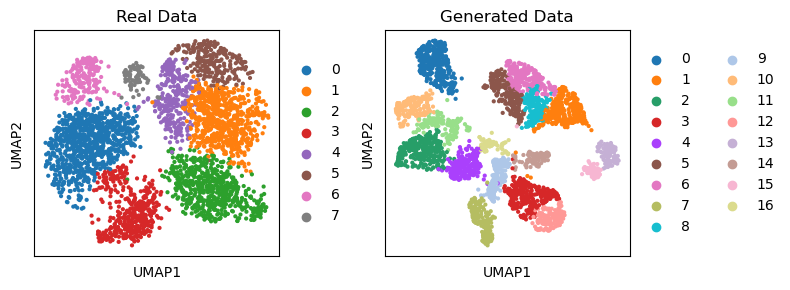

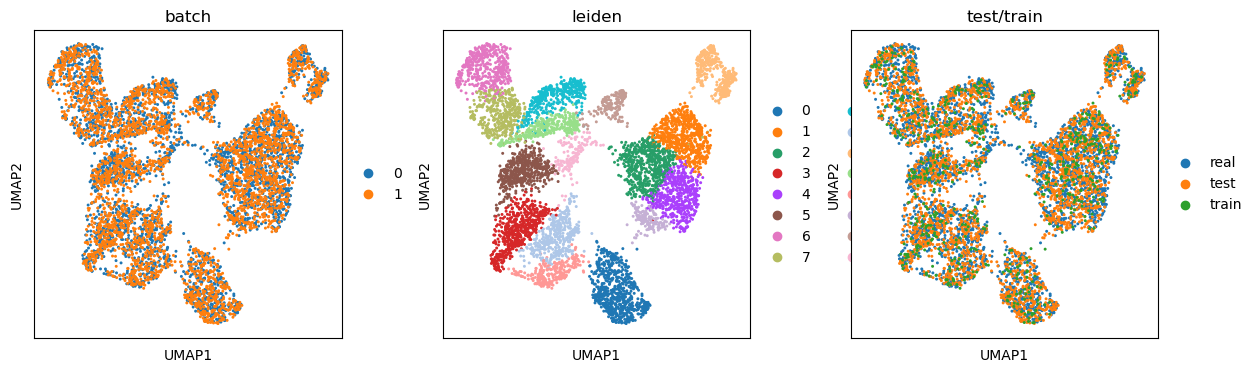

In [20]:
plt.rcParams['figure.figsize']=(2,2)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.obs['Real Data']=adata.obs['leiden']
sc.pl.umap(adata,color='Real Data',ax=axs[0], show=False)
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
gdata.obs['Generated Data']=gdata.obs['leiden']
sc.pl.umap(gdata,color='Generated Data',ax=axs[1], show=False)
plt.tight_layout()
plt.show()
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
plt.rcParams['figure.figsize']=(4,4)
cdata.obs['test/train']=cdata.obs['test/train'].astype(str).replace('nan', 'real')
sc.pl.umap(cdata,color=['batch','leiden','test/train'])

# Visualize mCG to GEX reconstruction

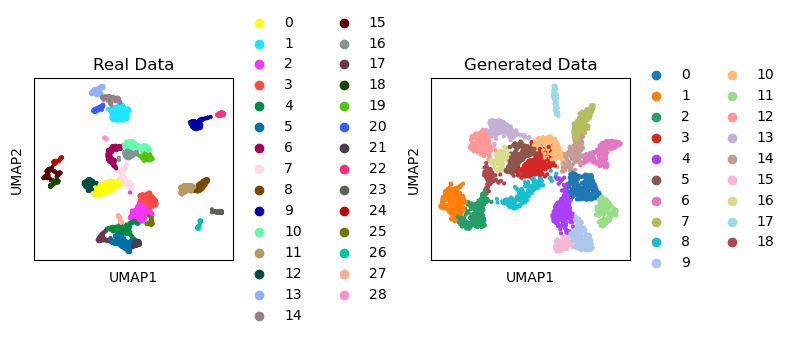

2025-02-01 13:38:02,441 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-02-01 13:38:04,133 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-01 13:38:04,168 - harmonypy - INFO - Iteration 1 of 20
2025-02-01 13:38:05,526 - harmonypy - INFO - Iteration 2 of 20
2025-02-01 13:38:06,855 - harmonypy - INFO - Iteration 3 of 20
2025-02-01 13:38:08,155 - harmonypy - INFO - Iteration 4 of 20
2025-02-01 13:38:09,201 - harmonypy - INFO - Iteration 5 of 20
2025-02-01 13:38:10,342 - harmonypy - INFO - Converged after 5 iterations


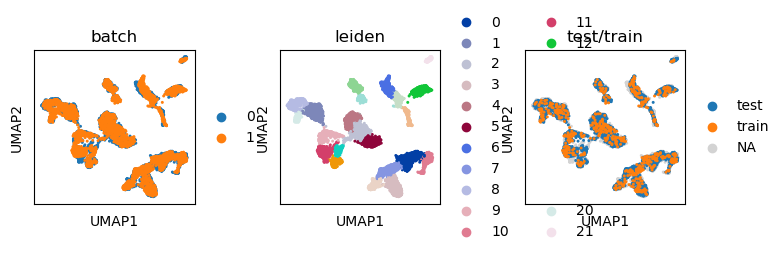

In [22]:
adata=AnnData(data_right)
gdata=AnnData(pd.DataFrame(recon_gex_train.detach().numpy())).concatenate(AnnData(pd.DataFrame(recon_gex_test.detach().numpy())))
gdata.obs.index=data_left_train.index.tolist() + data_left_test.index.tolist()
gdata.var.index=adata.var.index
gdata.obs['test/train']=gdata.obs['batch']
gdata.obs['test/train']=gdata.obs['test/train'].replace('0','test')
gdata.obs['test/train']=gdata.obs['test/train'].replace('1','train')

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.obs['Real Data']=adata.obs['leiden']
sc.pl.umap(adata,color='Real Data',ax=axs[0], show=False)
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
gdata.obs['Generated Data']=gdata.obs['leiden']
sc.pl.umap(gdata,color='Generated Data',ax=axs[1], show=False)
plt.tight_layout()
plt.show()
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)

sc.external.pp.harmony_integrate(cdata, 'batch',max_iter_harmony=20)
sc.pp.neighbors(cdata,n_pcs=20,n_neighbors=20,use_rep='X_pca_harmony')
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
sc.pl.umap(cdata,color=['batch','leiden','test/train'])

# Generate from right

In [24]:
recon_mcg_train,recon_gex_train=mcgae.predict_from_right(x_train_right)
print(recon_mcg_train.shape)
recon_mcg_test,recon_gex_test=mcgae.predict_from_right(x_test_right)
print(recon_mcg_test.shape)

torch.Size([2632, 1013])
torch.Size([658, 1013])


In [25]:
adata=AnnData(data_left)
gdata=AnnData(pd.DataFrame(recon_mcg_train.detach().numpy())).concatenate(AnnData(pd.DataFrame(recon_mcg_test.detach().numpy())))
gdata.obs.index=data_right_train.index.tolist() + data_right_test.index.tolist()
gdata.var.index=adata.var.index
gdata.obs['test/train']=gdata.obs['batch']
gdata.obs['test/train']=gdata.obs['test/train'].replace('0','test')
gdata.obs['test/train']=gdata.obs['test/train'].replace('1','train')

# Visualize GEX to mCG reconstruction

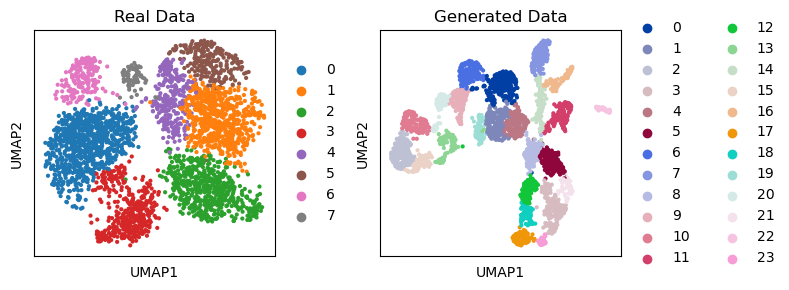

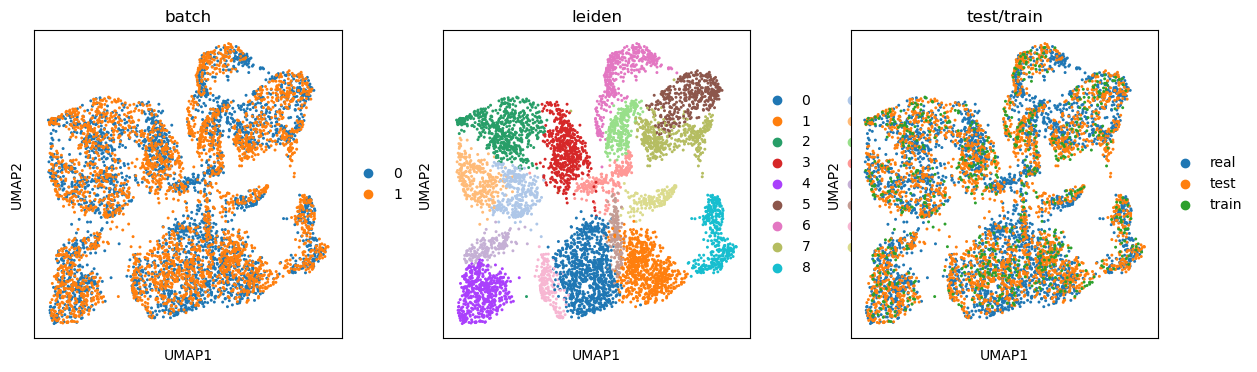

In [26]:
plt.rcParams['figure.figsize']=(2,2)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.obs['Real Data']=adata.obs['leiden']
sc.pl.umap(adata,color='Real Data',ax=axs[0], show=False)
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
gdata.obs['Generated Data']=gdata.obs['leiden']
sc.pl.umap(gdata,color='Generated Data',ax=axs[1], show=False)
plt.tight_layout()
plt.show()
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
plt.rcParams['figure.figsize']=(4,4)
cdata.obs['test/train']=cdata.obs['test/train'].astype(str).replace('nan', 'real')
sc.pl.umap(cdata,color=['batch','leiden','test/train'])

# Visualize GEX to GEX reconstruction

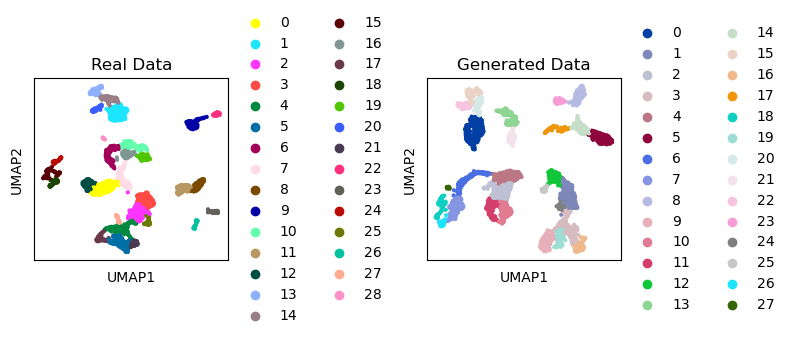

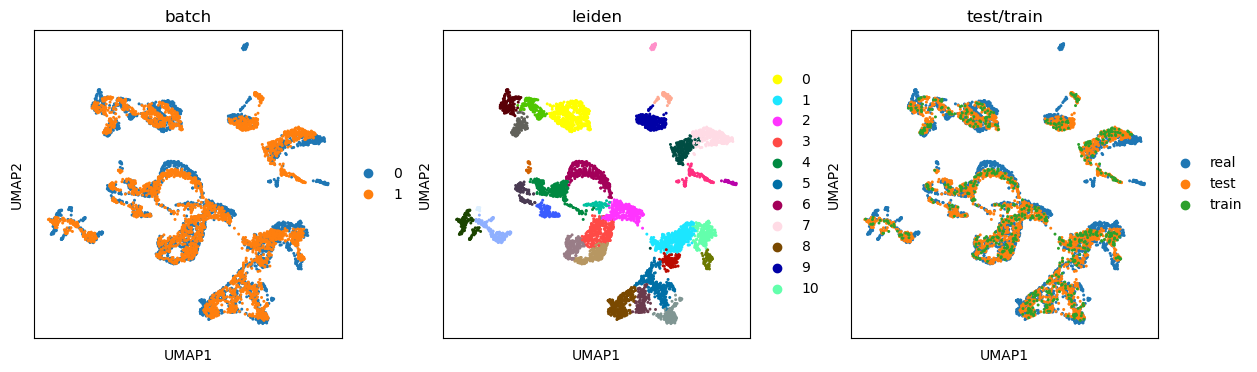

In [27]:
adata=AnnData(data_right)
gdata=AnnData(pd.DataFrame(recon_gex_train.detach().numpy())).concatenate(AnnData(pd.DataFrame(recon_gex_test.detach().numpy())))
gdata.obs.index=data_left_train.index.tolist() + data_left_test.index.tolist()
gdata.var.index=adata.var.index
gdata.obs['test/train']=gdata.obs['batch']
gdata.obs['test/train']=gdata.obs['test/train'].replace('0','test')
gdata.obs['test/train']=gdata.obs['test/train'].replace('1','train')

plt.rcParams['figure.figsize']=(2,2)
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.obs['Real Data']=adata.obs['leiden']
sc.pl.umap(adata,color='Real Data',ax=axs[0], show=False)
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
gdata.obs['Generated Data']=gdata.obs['leiden']
sc.pl.umap(gdata,color='Generated Data',ax=axs[1], show=False)
plt.tight_layout()
plt.show()
cdata=adata.concatenate(gdata)
sc.tl.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.leiden(cdata)
sc.tl.umap(cdata)
plt.rcParams['figure.figsize']=(4,4)
cdata.obs['test/train']=cdata.obs['test/train'].astype(str).replace('nan', 'real')
sc.pl.umap(cdata,color=['batch','leiden','test/train'])

# Latent space sampling

In [28]:
z_train_left=mcgae.sample_latent_from_left(x_train_left)
print(z_train_left.shape)
z_test_left=mcgae.sample_latent_from_left(x_test_left)
print(z_test_left.shape)

torch.Size([2632, 64])
torch.Size([658, 64])


In [29]:
# adata=AnnData(data_right)
gdata=AnnData(pd.DataFrame(z_train_left.detach().numpy())).concatenate(AnnData(pd.DataFrame(z_test_left.detach().numpy())))
gdata.obs.index=data_left_train.index.tolist() + data_left_test.index.tolist()
# gdata.var.index=adata.var.index
gdata.obs['test/train']=gdata.obs['batch']
gdata.obs['test/train']=gdata.obs['test/train'].replace('0','test')
gdata.obs['test/train']=gdata.obs['test/train'].replace('1','train')

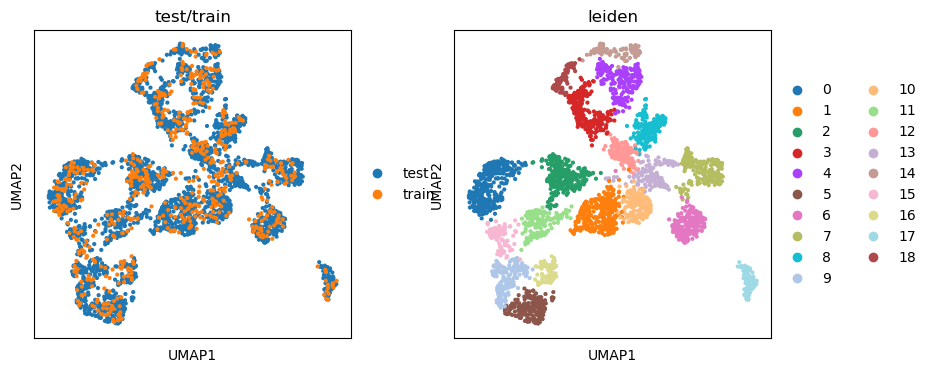

In [31]:
sc.tl.pca(gdata)
sc.pp.neighbors(gdata)
sc.tl.leiden(gdata)
sc.tl.umap(gdata)
# gdata.obs['Generated Data']=gdata.obs['leiden']
sc.pl.umap(gdata,color=['test/train','leiden'])